In [1]:
import awkward as ak
import numpy as np

import matplotlib.pyplot as plt
import mplhep as hep

import hist
from hist import Hist

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from topcoffea.modules.histEFT import HistEFT
NanoAODSchema.warn_missing_crossrefs = False

from coffea.analysis_tools import PackedSelection
from topcoffea.modules import utils
import topcoffea.modules.eft_helper as efth

In [2]:
fsmeft = "/cms/cephfs/data/store/user/hnelson2/noEFT/nanoGen/TT01j2l_SM/NanoGen_TT01j2l_SM/nanoGen_10016.root"
fpowheg = "/cms/cephfs/data/store/mc/RunIISummer20UL17NanoAODv9/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/2510000/74C36AED-4CB9-1A4D-A9E6-90278C68131C.root"

In [3]:
files = [fsmeft, fpowheg]

In [12]:
def is_clean(obj_A, obj_B, drmin=0.4):
    objB_near, objB_DR = obj_A.nearest(obj_B, return_metric=True)
    mask = ak.fill_none(objB_DR > drmin, True)
    return (mask)

def make_jets_plots(fname):
    # Load in events from root file
    events = NanoEventsFactory.from_root(
        fname,
        schemaclass=NanoAODSchema.v6,
        metadata={"dataset": "TTto2L2Nu"},
    ).events()
    
    genpart = events.GenPart
    is_final_mask = genpart.hasFlags(["fromHardProcess","isLastCopy"])
    
    ele  = genpart[is_final_mask & (abs(genpart.pdgId) == 11)]
    mu   = genpart[is_final_mask & (abs(genpart.pdgId) == 13)]
    tau  = genpart[is_final_mask & (abs(genpart.pdgId) == 15)]
    e_selec = ((ele.pt>20) & (abs(ele.eta)<2.5))
    m_selec = ((mu.pt>20) & (abs(mu.eta)<2.5))
    t_selec = ((tau.pt>20) & (abs(tau.eta)<2.5))
    
    leps = ak.concatenate([ele[e_selec], mu[m_selec], tau[t_selec]], axis=1)
    
    jets = events.GenJet
    njets = ak.num(jets)
    
    non_zero_jets = jets[njets>0]
    j0 = non_zero_jets[ak.argmax(non_zero_jets.pt, axis=-1, keepdims=True)]
    jets_pt = ak.flatten(non_zero_jets.pt)
    
    non_zero_leps = leps[njets>0]
    clean_jets = non_zero_jets[is_clean(non_zero_jets, non_zero_leps, drmin=0.4)]
    # clean0 = clean_jets[ak.argmax(clean_jets.pt, axis=-1, keepdims=True)]
                           
    
    hists = {
        'njets' : Hist(hist.axis.Regular(bins=15, start=0, stop=15, name='njets')),
        'j0pt' : Hist(hist.axis.Regular(bins=100, start=0, stop=500, name='j0pt')),
        'jets_pt' : Hist(hist.axis.Regular(bins=100, start=0, stop=500, name='jets_pt')),
        # 'clean_j0pt' : Hist(hist.axis.Regular(bins=100, start=0, stop=500, name='clean_j0pt')),
        'clean_njets' : Hist(hist.axis.Regular(bins=10, start=0, stop=10, name='clean_njets')),
        'clean_njets_30GeV' : Hist(hist.axis.Regular(bins=10, start=0, stop=10, name='clean_njets_30GeV')),
    }

    hists['njets'].fill(njets)
    hists['j0pt'].fill(ak.flatten(j0.pt))
    hists['jets_pt'].fill(jets_pt)
    # hists['clean_j0pt'].fill(ak.flatten(clean0.pt))
    hists['clean_njets'].fill(ak.num(clean_jets))
    hists['clean_njets_30GeV'].fill(ak.num(clean_jets[clean_jets.pt>30]))
                           
    
    return hists

In [13]:
h_powheg = make_jets_plots(fpowheg)
h_smeft = make_jets_plots(fsmeft)

In [14]:
def make_comparison_plots(h1, h2, h1_name, h2_name, norm=True):
    hep.style.use("CMS")
    fig, ax = plt.subplots()
    hep.histplot(h1, density=norm, yerr=False, label=h1_name)
    hep.histplot(h2, density=norm, yerr=False, label=h2_name)
    ax.legend()
    # ax.set_xlim([0, 50])
    # ax.set_xticks(np.arange(0, 15, 1))
    
    return fig, ax 

/tmp/ipykernel_81683/35539890.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_81683/35539890.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_81683/35539890.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_81683/35539890.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_81683/35539890.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


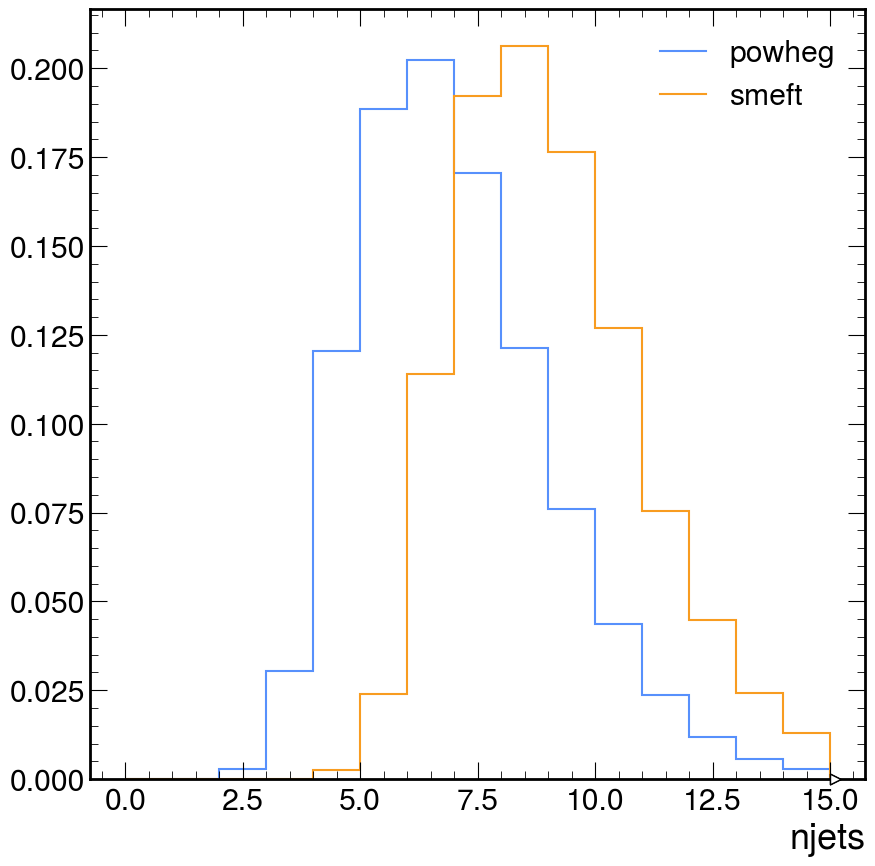

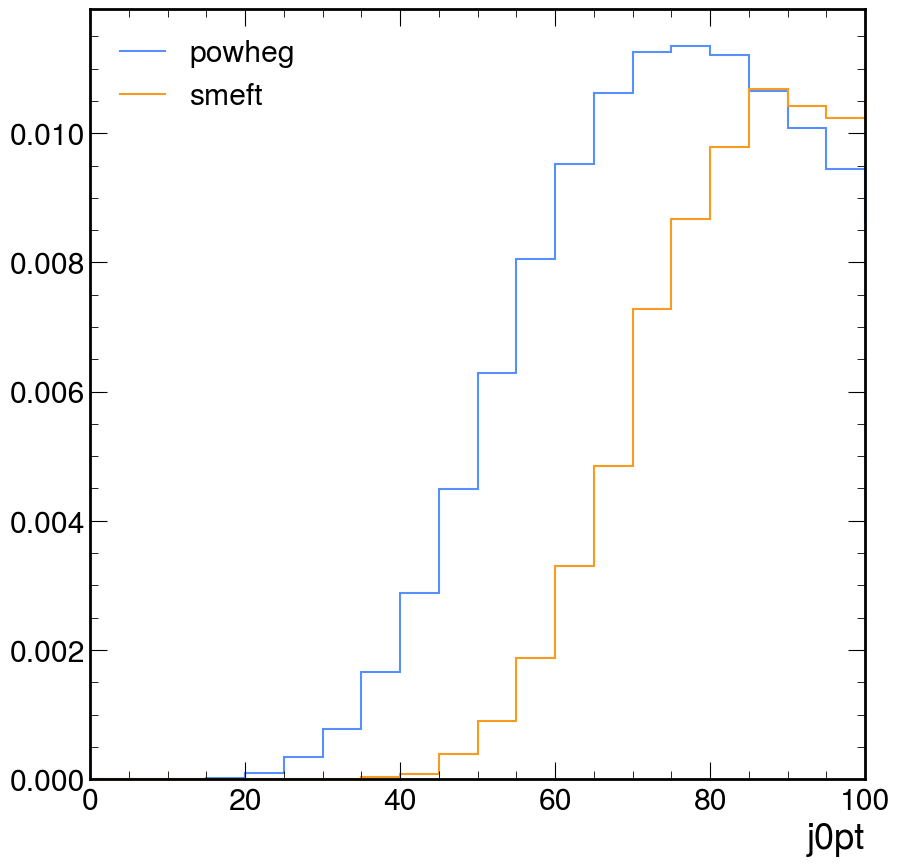

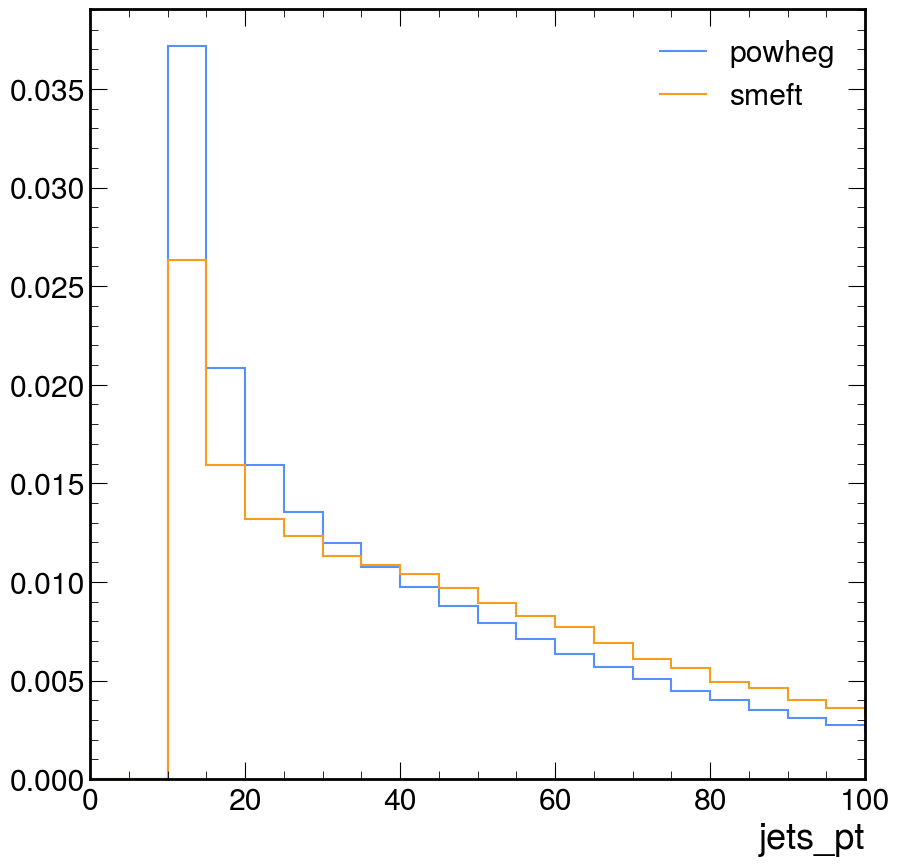

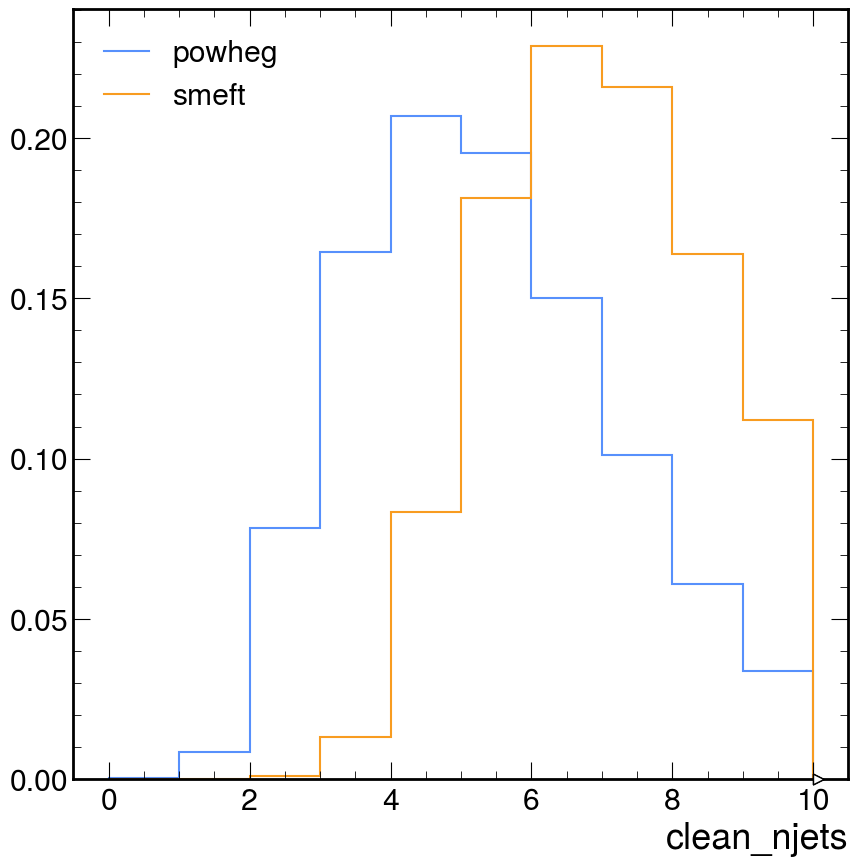

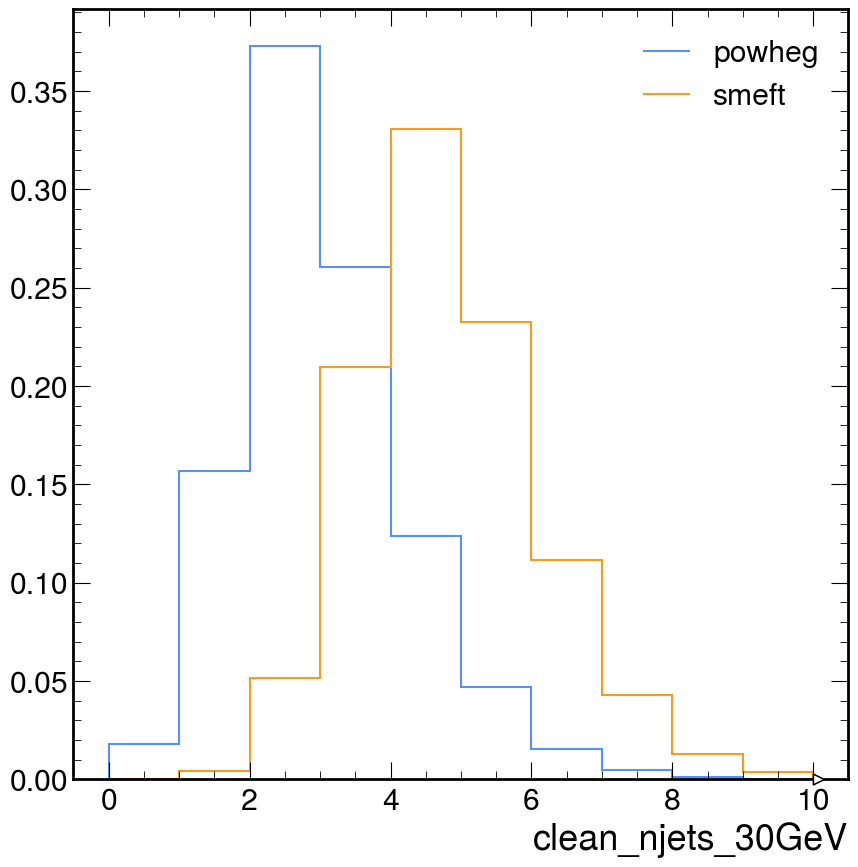

In [15]:
# name = 'njets'
# name = 'j0pt'
# name = 'jets_pt'
# print(f"smeft: {h_smeft[name].values()}")
# print(f"powheg: {h_powheg[name].values()}")
hist_list = h_powheg.keys()

for name in hist_list: 
    fig, ax = make_comparison_plots(h_powheg[name], h_smeft[name], "powheg", "smeft")
    if 'pt' in name: 
        ax.set_xlim([0, 100])
    fig.show()

In [2]:
f_smeft = "SMEFT_njets.pkl.gz"
f_powheg = "POWHEG_njets.pkl.gz"

smeft_hists = utils.get_hist_from_pkl(f_smeft, allow_empty=False)
powheg_hists = utils.get_hist_from_pkl(f_powheg, allow_empty=False)

In [4]:
smeft_hists

{'sow': HistEFT(
   StrCategory(['TT01j2l_SM'], growth=True, name='process'),
   Regular(1, 0, 2, name='sow', label='sum of weights'),
   Integer(0, 1, name='quadratic_term'),
   storage=Double()) # Sum: 1.0,
 'njets': HistEFT(
   StrCategory(['TT01j2l_SM'], growth=True, name='process'),
   Regular(10, 0, 10, name='njets'),
   Integer(0, 1, name='quadratic_term'),
   storage=Double()) # Sum: 1.0,
 'njets_clean': HistEFT(
   StrCategory(['TT01j2l_SM'], growth=True, name='process'),
   Regular(10, 0, 10, name='njets_clean', label='njets clean (lep)'),
   Integer(0, 1, name='quadratic_term'),
   storage=Double()) # Sum: 1.0,
 'njets_nu_clean': HistEFT(
   StrCategory(['TT01j2l_SM'], growth=True, name='process'),
   Regular(10, 0, 10, name='njets_nu_clean', label='njets clean (lep+nu)'),
   Integer(0, 1, name='quadratic_term'),
   storage=Double()) # Sum: 1.0}

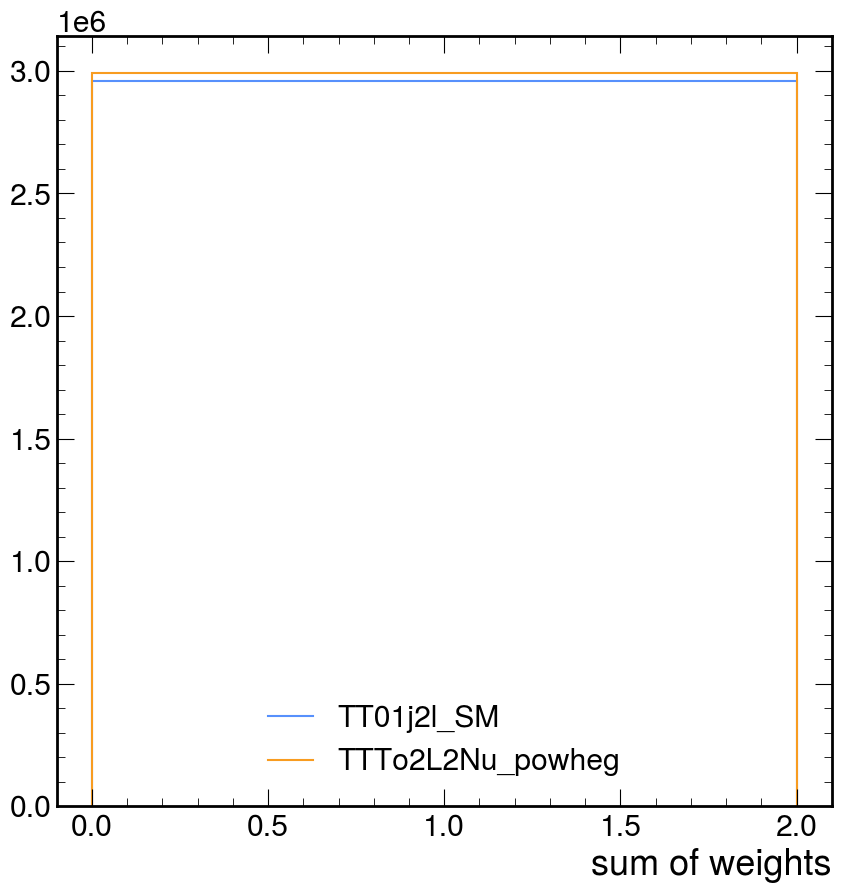

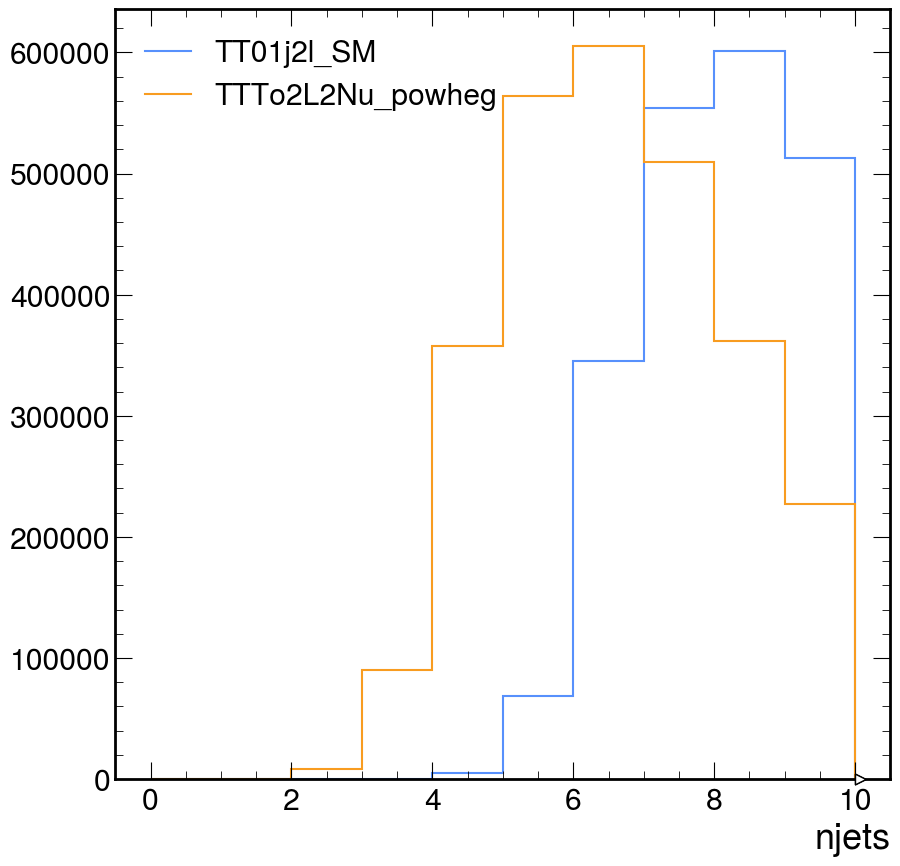

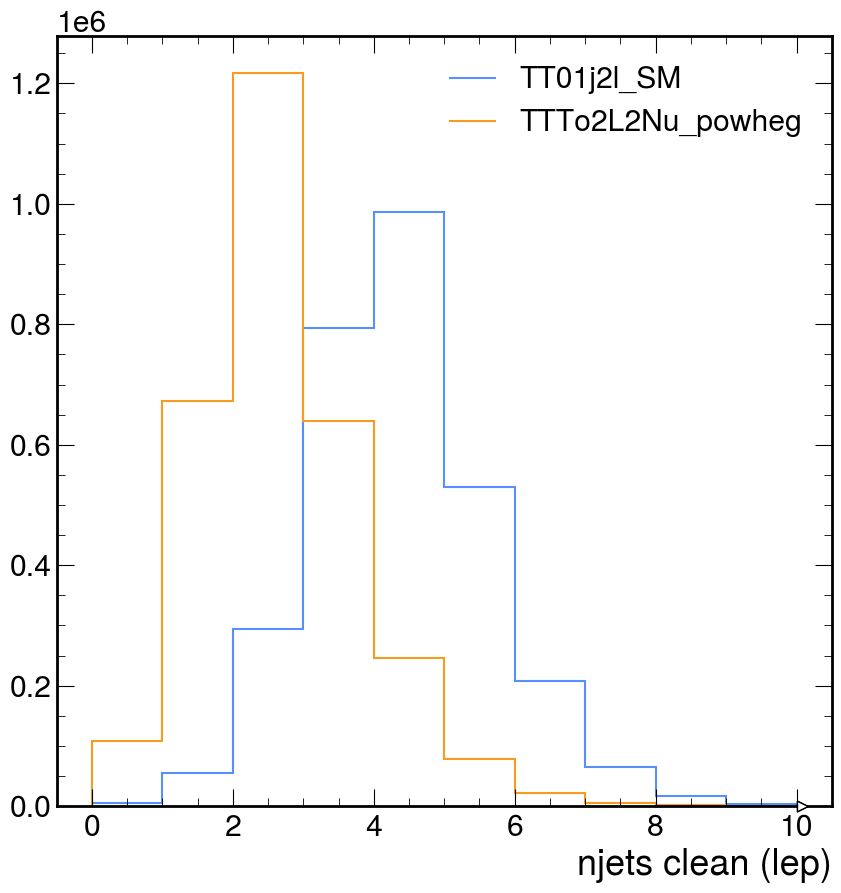

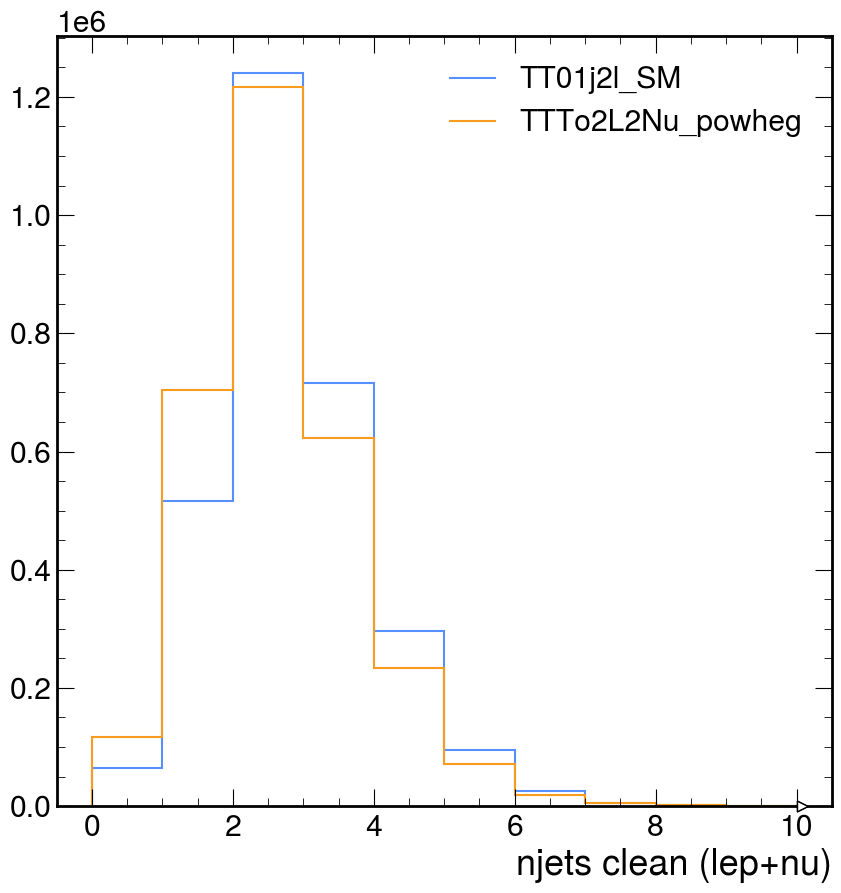

In [5]:
hist_list = smeft_hists.keys()
for name in hist_list:
    hep.style.use('CMS')
    h_smeft = smeft_hists[name].as_hist({})
    h_powheg = powheg_hists[name].as_hist({})
    
    fig, ax = plt.subplots()
    hep.style.use('CMS')
    
    h_smeft.plot1d(ax=ax, yerr=False)
    h_powheg.plot1d(ax=ax, yerr=False)
    
    ax.legend()